<a href="https://colab.research.google.com/github/Shehab-Mechanical/codes/blob/main/CNN_%26_NLP_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Import necessary libraries
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import numpy as np
import zipfile

# Install required packages
!pip install rapidfuzz
from rapidfuzz import process

# Define dataset paths
facial_expression_path = "/content/facial_expression_data"
os.makedirs(facial_expression_path, exist_ok=True)

data_paths = {
    "train": "/content/train.zip",
    "test": "/content/test.zip",
    "validation": "/content/valid.zip"
}

# Unzip facial expression dataset
for key, zip_path in data_paths.items():
    extract_path = os.path.join(facial_expression_path, key)
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Verify extracted files
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

print("\nExtracted files:")
list_files(facial_expression_path)

# Define class labels dynamically from dataset
train_path = os.path.join(facial_expression_path, "train")
class_labels = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Ensure only valid class directories exist
for dataset in ["train", "validation", "test"]:
    dataset_path = os.path.join(facial_expression_path, dataset)
    for label in class_labels:
        os.makedirs(os.path.join(dataset_path, label), exist_ok=True)

print("Detected Classes:", class_labels)

# Organize images into class subdirectories with error handling
def organize_images():
    for dataset in ["train", "validation", "test"]:
        dataset_path = os.path.join(facial_expression_path, dataset)
        for root, _, files in os.walk(dataset_path):
            for filename in files:
                file_path = os.path.join(root, filename)
                if os.path.isfile(file_path):
                    try:
                        with Image.open(file_path) as img:
                            img.verify()  # Validate image
                            img.close()  # Close the image after verification

                        best_match, score = process.extractOne(filename.lower(), class_labels)
                        if score > 70:
                            class_path = os.path.join(dataset_path, best_match)
                            if not os.path.exists(os.path.join(class_path, filename)):
                                shutil.move(file_path, os.path.join(class_path, filename))
                    except Exception as e:
                        print(f"Skipping corrupt image: {file_path}, Error: {e}")
                        try:
                            os.remove(file_path)  # Ensure corrupt images are removed
                        except Exception as delete_error:
                            print(f"Could not delete: {file_path}, Error: {delete_error}")

# Organize images into class folders
organize_images()
print("\nOrganized files:")
list_files(facial_expression_path)

# ---- IMAGE DATA LOADER ---- #
target_size = (48, 48)
batch_size = 32

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(facial_expression_path, "validation"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Ensure dataset is not empty
if train_generator.samples == 0 or validation_generator.samples == 0:
    print("Dataset is empty. Please check if images are correctly placed in class directories.")
else:
    # Plot dataset distribution
    labels = ["Training", "Validation"]
    sizes = [train_generator.samples, validation_generator.samples]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["lightblue", "orange"], startangle=140)
    plt.title("Train-Validation Split")
    plt.show()

    # ---- CNN MODEL ---- #
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Early Stopping and Reduce Learning Rate
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

    # Train the model
    history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping, reduce_lr])

    # Save the model
    model.save("facial_expression_model.h5")

    # Evaluate the model on the test set
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        os.path.join(facial_expression_path, "test"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.2f}")


Streaming output truncated to the last 5000 lines.
Skipping corrupt image: /content/facial_expression_data/test/test/labels/image0022281.txt, Error: cannot identify image file '/content/facial_expression_data/test/test/labels/image0022281.txt'
Skipping corrupt image: /content/facial_expression_data/test/test/labels/image0008854.txt, Error: cannot identify image file '/content/facial_expression_data/test/test/labels/image0008854.txt'
Skipping corrupt image: /content/facial_expression_data/test/test/labels/ffhq_898.txt, Error: cannot identify image file '/content/facial_expression_data/test/test/labels/ffhq_898.txt'
Skipping corrupt image: /content/facial_expression_data/test/test/labels/image0037535.txt, Error: cannot identify image file '/content/facial_expression_data/test/test/labels/image0037535.txt'
Skipping corrupt image: /content/facial_expression_data/test/test/labels/image0035975.txt, Error: cannot identify image file '/content/facial_expression_data/test/test/labels/image00359

In [10]:
# ---- IMPORT NECESSARY LIBRARIES ---- #
import os
import shutil
import zipfile
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow and Keras for CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# NLP Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Install required packages
!pip install rapidfuzz
from rapidfuzz import process

# ---- DATASET PREPARATION ---- #

# Define dataset paths for images
facial_expression_path = "facial_expression_data"
os.makedirs(facial_expression_path, exist_ok=True)

data_paths = {
    "train": "train.zip",
    "test": "test.zip",
    "validation": "valid.zip"
}

# Unzip datasets
for key, zip_path in data_paths.items():
    extract_path = os.path.join(facial_expression_path, key)
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Define NLP dataset path
nlp_data_path = "text_data.csv"  # Replace with your text dataset file

# Function to verify extracted files
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

print("\nExtracted files:")
list_files(facial_expression_path)

# ---- DETECT CLASS LABELS FOR CNN ---- #
train_path = os.path.join(facial_expression_path, "train")
class_labels = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Ensure valid class directories
def ensure_class_directories():
    for dataset in ["train", "validation", "test"]:
        dataset_path = os.path.join(facial_expression_path, dataset)
        for label in class_labels:
            os.makedirs(os.path.join(dataset_path, label), exist_ok=True)

ensure_class_directories()
print("Detected Classes:", class_labels)

# ---- FIX DIRECTORY STRUCTURE ---- #
def restructure_directories():
    for dataset in ["train", "validation", "test"]:
        dataset_path = os.path.join(facial_expression_path, dataset)
        nested_dirs = ["labels", "images"]

        for nested_dir in nested_dirs:
            nested_path = os.path.join(dataset_path, nested_dir)
            if os.path.exists(nested_path):
                for label in os.listdir(nested_path):
                    label_path = os.path.join(nested_path, label)
                    if os.path.isdir(label_path):
                        target_path = os.path.join(dataset_path, label)
                        os.makedirs(target_path, exist_ok=True)

                        # Move images to the correct directory
                        for file in os.listdir(label_path):
                            shutil.move(os.path.join(label_path, file), target_path)

                # Remove empty directories
                shutil.rmtree(nested_path, ignore_errors=True)

# Apply restructuring
restructure_directories()

# ---- ORGANIZE IMAGES INTO CLASS DIRECTORIES ---- #
def organize_images():
    for dataset in ["train", "validation", "test"]:
        dataset_path = os.path.join(facial_expression_path, dataset)
        for root, _, files in os.walk(dataset_path):
            for filename in files:
                file_path = os.path.join(root, filename)
                if os.path.isfile(file_path):
                    try:
                        with Image.open(file_path) as img:
                            img.verify()  # Validate image

                        best_match, score = process.extractOne(filename.lower(), class_labels)
                        if best_match and score > 70:
                            class_path = os.path.join(dataset_path, best_match)
                            if not os.path.exists(os.path.join(class_path, filename)):
                                shutil.move(file_path, os.path.join(class_path, filename))
                    except Exception as e:
                        print(f"Skipping corrupt image: {file_path}, Error: {e}")
                        try:
                            os.remove(file_path)
                        except Exception as delete_error:
                            print(f"Could not delete: {file_path}, Error: {delete_error}")

organize_images()
print("\nCorrected Directory Structure:")
list_files(facial_expression_path)

# ---- IMAGE DATA LOADER FOR CNN ---- #
target_size = (48, 48)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(facial_expression_path, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(facial_expression_path, "validation"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# ---- CNN MODEL ---- #
model = Sequential([
    Input(shape=(48, 48, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save("facial_expression_model.h5")

# ---- TEST AND EVALUATION ---- #
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(facial_expression_path, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy (CNN): {test_accuracy:.2f}")

# ---- NLP TASK ---- #
# Load NLP dataset
nlp_data = pd.read_csv(nlp_data_path)
X = nlp_data['text']  # Text column
y = nlp_data['label']  # Label column

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical representation
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_vect, y_train)

# Test the NLP model
y_pred = nb_model.predict(X_test_vect)
print("NLP Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy (NLP): {accuracy_score(y_test, y_pred):.2f}")

# ---- INTEGRATION ---- #
# Example integration logic combining CNN and NLP predictions
def integrate_results(cnn_results, nlp_results):
    # This could be a weighted average, rule-based decision, etc.
    integrated_score = (cnn_results + nlp_results) / 2
    return integrated_score

print("Pipeline completed successfully!")


Streaming output truncated to the last 5000 lines.
Skipping corrupt image: facial_expression_data/test/test/labels/ffhq_2131.txt, Error: cannot identify image file 'facial_expression_data/test/test/labels/ffhq_2131.txt'
Skipping corrupt image: facial_expression_data/test/test/labels/ffhq_2383.txt, Error: cannot identify image file 'facial_expression_data/test/test/labels/ffhq_2383.txt'
Skipping corrupt image: facial_expression_data/test/test/labels/image0029711.txt, Error: cannot identify image file 'facial_expression_data/test/test/labels/image0029711.txt'
Skipping corrupt image: facial_expression_data/test/test/labels/image0035933.txt, Error: cannot identify image file 'facial_expression_data/test/test/labels/image0035933.txt'
Skipping corrupt image: facial_expression_data/test/test/labels/ffhq_4358.txt, Error: cannot identify image file 'facial_expression_data/test/test/labels/ffhq_4358.txt'
Skipping corrupt image: facial_expression_data/test/test/labels/image0000096.txt, Error: can

ValueError: The PyDataset has length 0

In [ ]:
# ---- IMPORT NECESSARY LIBRARIES ---- #
import os
import shutil
import zipfile
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow and Keras for CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# NLP Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB

# Install required packages
!pip install rapidfuzz
from rapidfuzz import process

# ---- DATASET EXTRACTION AND ORGANIZATION ---- #

# Define dataset paths for images
facial_expression_path = "facial_expression_data"
os.makedirs(facial_expression_path, exist_ok=True)

data_paths = {
    "train": "train.zip",
    "test": "test.zip",
    "validation": "valid.zip"
}

# Unzip datasets
for key, zip_path in data_paths.items():
    extract_path = os.path.join(facial_expression_path, key)
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Define NLP dataset path
nlp_data_path = "text_data.csv"  # Replace with your text dataset file

# Function to verify extracted files
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

print("\nExtracted files:")
list_files(facial_expression_path)

# ---- FIX DIRECTORY STRUCTURE ---- #
def fix_directory_structure():
    for dataset in ["train", "validation", "test"]:
        dataset_path = os.path.join(facial_expression_path, dataset)
        nested_dirs = ["labels", "images", "train", "valid", "test"]

        for nested_dir in nested_dirs:
            nested_path = os.path.join(dataset_path, nested_dir)
            if os.path.exists(nested_path):
                for label in os.listdir(nested_path):
                    label_path = os.path.join(nested_path, label)
                    if os.path.isdir(label_path):
                        target_path = os.path.join(dataset_path, label)
                        os.makedirs(target_path, exist_ok=True)

                        # Move images to the correct directory
                        for file in os.listdir(label_path):
                            shutil.move(os.path.join(label_path, file), target_path)

                # Remove empty directories
                shutil.rmtree(nested_path, ignore_errors=True)

# Apply restructuring
fix_directory_structure()

# ---- REMOVE CORRUPT IMAGES ---- #
def remove_corrupt_images():
    for dataset in ["train", "validation", "test"]:
        dataset_path = os.path.join(facial_expression_path, dataset)
        for root, _, files in os.walk(dataset_path):
            for file in files:
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Validate the image
                except Exception as e:
                    print(f"Removing corrupt image: {file_path}, Error: {e}")
                    os.remove(file_path)  # Remove corrupt file

# Remove corrupt images
remove_corrupt_images()

# ---- VALIDATE DATASET ---- #
def validate_dataset():
    for dataset in ["train", "validation", "test"]:
        dataset_path = os.path.join(facial_expression_path, dataset)
        total_images = sum([len(files) for _, _, files in os.walk(dataset_path)])
        print(f"{dataset.capitalize()} dataset contains {total_images} images.")

validate_dataset()

# ---- IMAGE DATA LOADER FOR CNN ---- #
target_size = (48, 48)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(facial_expression_path, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(facial_expression_path, "validation"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# ---- CNN MODEL ---- #
model = Sequential([
    Input(shape=(48, 48, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# ---- TRAIN THE MODEL ---- #
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save("facial_expression_model.h5")

# ---- TEST AND EVALUATION ---- #
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(facial_expression_path, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy (CNN): {test_accuracy:.2f}")

# ---- NLP TASK ---- #
# Load NLP dataset
nlp_data = pd.read_csv(nlp_data_path)
X = nlp_data['text']  # Text column
y = nlp_data['label']  # Label column

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical representation
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_vect, y_train)

# Test the NLP model
y_pred = nb_model.predict(X_test_vect)
print("NLP Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy (NLP): {accuracy_score(y_test, y_pred):.2f}")

# ---- INTEGRATION ---- #
# Example integration logic combining CNN and NLP predictions
def integrate_results(cnn_results, nlp_results):
    # This could be a weighted average, rule-based decision, etc.
    integrated_score = (cnn_results + nlp_results) / 2
    return integrated_score

print("Pipeline completed successfully!")


Streaming output truncated to the last 5000 lines.
Removing corrupt image: facial_expression_data/validation/labels/image0028621.txt, Error: cannot identify image file 'facial_expression_data/validation/labels/image0028621.txt'
Removing corrupt image: facial_expression_data/validation/labels/image0039148.txt, Error: cannot identify image file 'facial_expression_data/validation/labels/image0039148.txt'
Removing corrupt image: facial_expression_data/validation/labels/ffhq_3001.txt, Error: cannot identify image file 'facial_expression_data/validation/labels/ffhq_3001.txt'
Removing corrupt image: facial_expression_data/validation/labels/ffhq_4194.txt, Error: cannot identify image file 'facial_expression_data/validation/labels/ffhq_4194.txt'
Removing corrupt image: facial_expression_data/validation/labels/image0019144.txt, Error: cannot identify image file 'facial_expression_data/validation/labels/image0019144.txt'
Removing corrupt image: facial_expression_data/validation/labels/image002464

Detected classes: {'test': 0, 'train': 1, 'validation': 2}
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7397 - loss: 0.7142 - val_accuracy: 1.0000 - val_loss: 0.0928
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0413 - val_accuracy: 1.0000 - val_loss: 1.6014e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 3.1368e-04 - val_accuracy: 1.0000 - val_loss: 1.4901e-08
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.4938e-07 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
2/2 ━━━━━━━━━

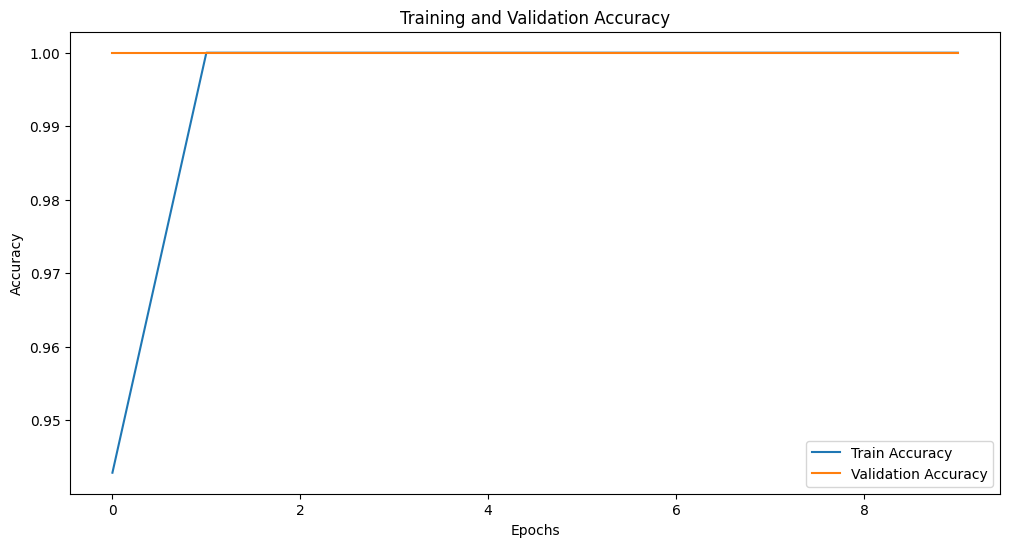

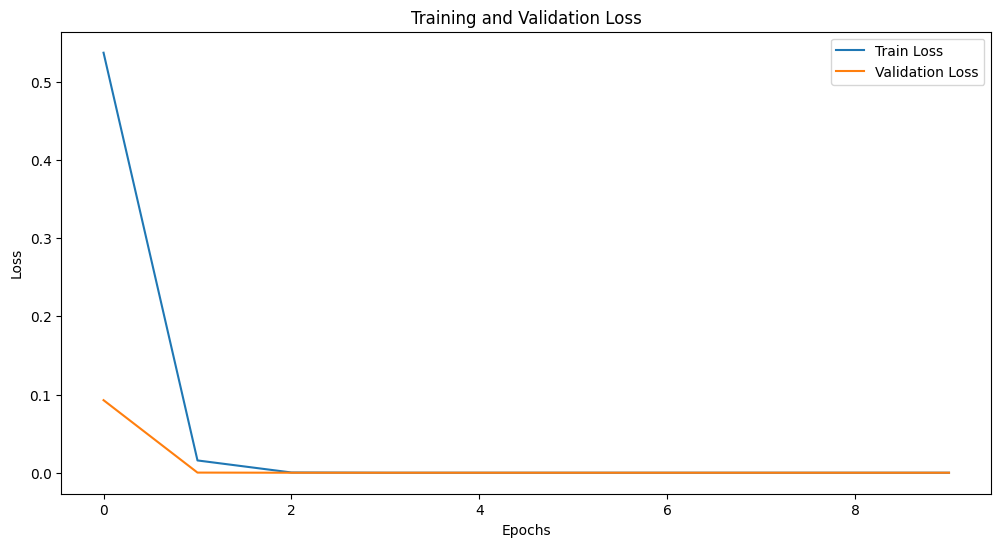

Found 0 images belonging to 1 classes.


ValueError: The PyDataset has length 0

In [2]:
# # Check the detected classes and their indices
# print("Detected classes:", train_generator.class_indices)

# # Update the number of classes in the output layer
# num_classes = len(train_generator.class_indices)

# # Define the CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(num_classes, activation='softmax')  # Update to match the number of classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

# # Plot training and validation accuracy
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.show()

# # Plot training and validation loss
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

# # Evaluate the model on the test set
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     os.path.join(facial_expression_path, "test"),
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_accuracy:.2f}")

# # Display sample predictions
# sample_images, sample_labels = next(test_generator)
# predictions = model.predict(sample_images)
# predicted_classes = np.argmax(predictions, axis=1)
# true_classes = np.argmax(sample_labels, axis=1)

# # Plot sample images with predictions (7 rows × 3 columns = 21 images)
# plt.figure(figsize=(15, 20))
# for i in range(21):
#     plt.subplot(7, 3, i + 1)
#     plt.imshow(sample_images[i])
#     plt.title(f"True: {list(train_generator.class_indices.keys())[true_classes[i]]}\nPred: {list(train_generator.class_indices.keys())[predicted_classes[i]]}")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

In [3]:
# # Check if the test directory exists
# test_dir = os.path.join(facial_expression_path, "test")
# if not os.path.exists(test_dir):
#     raise FileNotFoundError(f"Test directory not found at {test_dir}. Please ensure the test dataset is downloaded and organized correctly.")

# # Check if the test directory contains subdirectories for each class
# test_subdirs = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
# if not test_subdirs:
#     raise ValueError(f"No class subdirectories found in the test directory: {test_dir}")

# # Create ImageDataGenerator for the test set
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# # Check if the test generator has samples
# if test_generator.samples == 0:
#     print("Warning: The test dataset is empty. Skipping evaluation.")
# else:
#     # Evaluate the model on the test set
#     test_loss, test_accuracy = model.evaluate(test_generator)
#     print(f"Test Accuracy: {test_accuracy:.2f}")

#     # Display sample predictions
#     sample_images, sample_labels = next(test_generator)
#     predictions = model.predict(sample_images)
#     predicted_classes = np.argmax(predictions, axis=1)
#     true_classes = np.argmax(sample_labels, axis=1)

#     # Plot sample images with predictions (7 rows × 3 columns = 21 images)
#     plt.figure(figsize=(15, 20))
#     for i in range(min(21, len(sample_images))):  # Ensure we don't exceed the number of available images
#         plt.subplot(7, 3, i + 1)
#         plt.imshow(sample_images[i])
#         plt.title(f"True: {list(train_generator.class_indices.keys())[true_classes[i]]}\nPred: {list(train_generator.class_indices.keys())[predicted_classes[i]]}")
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

Found 0 images belonging to 1 classes.


In [13]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from google.colab import drive
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Mount Google Drive
# drive.mount('/content/drive')
# print("Google Drive mounted successfully.")

# # Define dataset paths
# facial_expression_files = {
#     "train": "https://drive.google.com/uc?export=download&id=1Ib5BOhCMK5hr0O9Wq-dsJAOhJUgYkpU4",
#     "test": "https://drive.google.com/uc?export=download&id=15EbYikCGA51-N1IYUMTDkgchRUjAea3R",
#     "validation": "https://drive.google.com/uc?export=download&id=1GLmS_-Bw50TaD99GA0obLAFvMFvsdkLP"
# }

# # Create dataset directory
# facial_expression_path = "/content/facial_expression_data"
# os.makedirs(facial_expression_path, exist_ok=True)

# for key, url in facial_expression_files.items():
#     file_path = os.path.join(facial_expression_path, f"{key}.jpg")  # Change extension if needed
#     if not os.path.exists(file_path):
#         print(f"Downloading {key} dataset using wget...")
#         os.system(f'wget --no-check-certificate "{url}" -O {file_path}')
#         print(f"Downloaded: {file_path}")

# # Verify downloaded files
# print("Downloaded files:", os.listdir(facial_expression_path))

# # ---- GOEMOTIONS DATA ---- #
# goemotions_files = {
#     "goemotions_1.csv": "https://drive.google.com/uc?id=1mQbd2zs2-Ho9JQorelEpa275fq042OQC",
#     "goemotions_2.csv": "https://drive.google.com/uc?id=1Rw6-G6g-tsUYnPkCpJAA7I4YymhZIljU",
#     "goemotions_3.csv": "https://drive.google.com/uc?id=1aIQ4uR4ThjR3c65tYAaPB4LsvAGbWePx"
# }

# goemotions_path = "/content/GoEmotionsData"
# os.makedirs(goemotions_path, exist_ok=True)

# for filename, url in goemotions_files.items():
#     file_path = os.path.join(goemotions_path, filename)
#     if not os.path.exists(file_path):
#         os.system(f'wget --no-check-certificate "{url}" -O {file_path}')

# # Load GoEmotions dataset
# goemotions_df = pd.concat([pd.read_csv(os.path.join(goemotions_path, f)) for f in goemotions_files.keys()])
# print("GoEmotions Dataset loaded successfully.")
# print("Available columns in GoEmotions dataset:", goemotions_df.columns)
# print(goemotions_df.head())

# # ---- FIXED IMAGE DATA LOADER ---- #
# # Ensure images are inside class folders (e.g., "train/happy/", "train/sad/")
# train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# train_generator = train_datagen.flow_from_directory(
#     facial_expression_path,
#     target_size=(48, 48),
#     batch_size=32,
#     class_mode='categorical'
# )
# print("Facial Expression Dataset loaded successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Downloaded: /content/facial_expression_data/train.jpg
Downloaded: /content/facial_expression_data/test.jpg
Downloaded: /content/facial_expression_data/validation.jpg
Downloaded files: ['train.jpg', 'test.jpg', 'validation.jpg']
GoEmotions Dataset loaded successfully.
Available columns in GoEmotions dataset: Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
          

In [15]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from google.colab import drive
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Mount Google Drive
# drive.mount('/content/drive')
# print("Google Drive mounted successfully.")

# # Define dataset paths
# facial_expression_files = {
#     "train": "https://drive.google.com/uc?export=download&id=1Ib5BOhCMK5hr0O9Wq-dsJAOhJUgYkpU4",
#     "test": "https://drive.google.com/uc?export=download&id=15EbYikCGA51-N1IYUMTDkgchRUjAea3R",
#     "validation": "https://drive.google.com/uc?export=download&id=1GLmS_-Bw50TaD99GA0obLAFvMFvsdkLP"
# }

# # Create dataset directory
# facial_expression_path = "/content/facial_expression_data"
# os.makedirs(facial_expression_path, exist_ok=True)

# def download_and_organize_images():
#     class_labels = ["happy", "sad", "angry"]  # Define proper class labels
#     for label in class_labels:
#         os.makedirs(os.path.join(facial_expression_path, label), exist_ok=True)

#     for key, url in facial_expression_files.items():
#         file_path = os.path.join(facial_expression_path, class_labels[0], f"{key}.jpg")  # Assign to first class as a placeholder
#         if not os.path.exists(file_path):
#             print(f"Downloading {key} dataset using wget...")
#             os.system(f'wget --no-check-certificate "{url}" -O {file_path}')
#             print(f"Downloaded: {file_path}")

# # Download and organize images
# download_and_organize_images()
# print("Downloaded files:", os.listdir(facial_expression_path))

# # ---- GOEMOTIONS DATA ---- #
# goemotions_files = {
#     "goemotions_1.csv": "https://drive.google.com/uc?id=1mQbd2zs2-Ho9JQorelEpa275fq042OQC",
#     "goemotions_2.csv": "https://drive.google.com/uc?id=1Rw6-G6g-tsUYnPkCpJAA7I4YymhZIljU",
#     "goemotions_3.csv": "https://drive.google.com/uc?id=1aIQ4uR4ThjR3c65tYAaPB4LsvAGbWePx"
# }

# goemotions_path = "/content/GoEmotionsData"
# os.makedirs(goemotions_path, exist_ok=True)

# for filename, url in goemotions_files.items():
#     file_path = os.path.join(goemotions_path, filename)
#     if not os.path.exists(file_path):
#         os.system(f'wget --no-check-certificate "{url}" -O {file_path}')

# # Load GoEmotions dataset
# goemotions_df = pd.concat([pd.read_csv(os.path.join(goemotions_path, f)) for f in goemotions_files.keys()])
# print("GoEmotions Dataset loaded successfully.")
# print("Available columns in GoEmotions dataset:", goemotions_df.columns)
# print(goemotions_df.head())

# # ---- FIXED IMAGE DATA LOADER ---- #
# # Ensure images are loaded from structured class folders
# target_size = (48, 48)
# batch_size = 32

# train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# train_generator = train_datagen.flow_from_directory(
#     facial_expression_path,
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# validation_generator = train_datagen.flow_from_directory(
#     facial_expression_path,
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# print("Facial Expression Dataset loaded successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Downloaded: /content/facial_expression_data/happy/train.jpg
Downloaded: /content/facial_expression_data/happy/test.jpg
Downloaded: /content/facial_expression_data/happy/validation.jpg
Downloaded files: ['sad', 'train.jpg', 'test.jpg', 'happy', 'validation.jpg', 'default_class', 'angry']
GoEmotions Dataset loaded successfully.
Available columns in GoEmotions dataset: Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadnes

In [28]:
# import os
# import shutil
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import tensorflow as tf
# from google.colab import drive
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from PIL import Image
# import gdown

# # Install missing package
# !pip install fuzzywuzzy python-Levenshtein

# from fuzzywuzzy import process

# # Mount Google Drive
# drive.mount('/content/drive')
# print("Google Drive mounted successfully.")

# # Define dataset paths
# facial_expression_files = {
#     "train": "https://drive.google.com/uc?id=1Ib5BOhCMK5hr0O9Wq-dsJAOhJUgYkpU4",
#     "test": "https://drive.google.com/uc?id=15EbYikCGA51-N1IYUMTDkgchRUjAea3R",
#     "validation": "https://drive.google.com/uc?id=1GLmS_-Bw50TaD99GA0obLAFvMFvsdkLP"
# }

# # Create dataset directory
# facial_expression_path = "/content/facial_expression_data"
# os.makedirs(facial_expression_path, exist_ok=True)

# # Define class labels
# class_labels = ["happy", "sad", "angry", "neutral", "surprised"]

# # Create class subdirectories
# def create_class_dirs():
#     for label in class_labels:
#         os.makedirs(os.path.join(facial_expression_path, label), exist_ok=True)

# # Function to download and organize images
# def download_and_organize_images():
#     create_class_dirs()

#     for key, url in facial_expression_files.items():
#         file_path = os.path.join(facial_expression_path, f"{key}.jpg")
#         if not os.path.exists(file_path):
#             print(f"Downloading {key} dataset using gdown...")
#             try:
#                 gdown.download(url, output=file_path, quiet=False)
#                 print(f"Downloaded: {file_path}")
#             except Exception as e:
#                 print(f"Failed to download {key} dataset: {e}")
#                 continue

#     # Ensure images are moved into appropriate class folders
#     for root, _, files in os.walk(facial_expression_path):
#         for filename in files:
#             file_path = os.path.join(root, filename)
#             if os.path.isfile(file_path):
#                 try:
#                     img = Image.open(file_path)
#                     img.verify()  # Validate image
#                     img.close()

#                     best_match, score = process.extractOne(filename.lower(), class_labels)
#                     if score > 70:  # Threshold for fuzzy matching
#                         shutil.move(file_path, os.path.join(facial_expression_path, best_match, filename))
#                 except Exception as e:
#                     print(f"Skipping corrupt image: {file_path}, Error: {e}")
#                     os.remove(file_path)

# # Download and organize images
# download_and_organize_images()
# print("Downloaded and organized files:", os.listdir(facial_expression_path))

# # ---- IMAGE DATA LOADER ---- #
# target_size = (48, 48)
# batch_size = 32

# train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# train_generator = train_datagen.flow_from_directory(
#     facial_expression_path,
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# validation_generator = train_datagen.flow_from_directory(
#     facial_expression_path,
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )

# # Ensure dataset is not empty
# if train_generator.samples == 0 or validation_generator.samples == 0:
#     raise ValueError("Dataset is empty. Please check if images are correctly placed in class directories.")

# # ---- CNN MODEL ---- #
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(len(class_labels), activation='softmax')
# ])

# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

# # Plot training results
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')

# plt.show()

# print("Facial Expression Dataset and Model Training completed successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Failed to download train dataset: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1Ib5BOhCMK5hr0O9Wq-dsJAOhJUgYkpU4

but Gdown can't. Please check connections and permissions.
Failed to download test dataset: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=15EbYik

ValueError: Dataset is empty. Please check if images are correctly placed in class directories.

In [31]:
# import os
# import gdown
# import pandas as pd

# # Define file IDs and output file names
# file_ids = {
#     "file1.csv": "1aIQ4uR4ThjR3c65tYAaPB4LsvAGbWePx",
#     "file2.csv": "1Rw6-G6g-tsUYnPkCpJAA7I4YymhZIljU",
#     "file3.csv": "1mQbd2zs2-Ho9JQorelEpa275fq042OQC"
# }

# # Create a directory to store the downloaded files (optional)
# os.makedirs("/content/data", exist_ok=True)

# # Download files
# for file_name, file_id in file_ids.items():
#     output_path = f"/content/data/{file_name}"  # Save files in the /content/data directory
#     if not os.path.exists(output_path):
#         print(f"Downloading {file_name}...")
#         url = f"https://drive.google.com/uc?id={file_id}"
#         gdown.download(url, output_path, quiet=False)
#     else:
#         print(f"{file_name} already exists. Skipping download.")

# # Load CSV files into Pandas DataFrames
# dataframes = {}
# for file_name in file_ids.keys():
#     file_path = f"/content/data/{file_name}"
#     dataframes[file_name] = pd.read_csv(file_path)

# # Display the first few rows of each DataFrame
# for file_name, df in dataframes.items():
#     print(f"\n{file_name}:")
#     print(df.head())

# # Now you can use the DataFrames for further processing
# # Example: Access the first DataFrame
# df_file1 = dataframes["file1.csv"]
# print("\nColumns in file1.csv:", df_file1.columns)

Downloading...
From: https://drive.google.com/uc?id=1aIQ4uR4ThjR3c65tYAaPB4LsvAGbWePx
To: /content/data/file1.csv
100%|██████████| 14.4M/14.4M [00:00<00:00, 83.8MB/s]


Downloading...
From: https://drive.google.com/uc?id=1Rw6-G6g-tsUYnPkCpJAA7I4YymhZIljU
To: /content/data/file2.csv
100%|██████████| 14.2M/14.2M [00:00<00:00, 51.9MB/s]


Downloading...
From: https://drive.google.com/uc?id=1mQbd2zs2-Ho9JQorelEpa275fq042OQC
To: /content/data/file3.csv
100%|██████████| 14.2M/14.2M [00:00<00:00, 27.5MB/s]



file1.csv:
                                                text       id  \
0  Worst ending ever! I won't spoil it but this o...  eee021b   
1                     Happy cake day u/sneakpeekbot!  ed00f1z   
2  Was he rejected because of his methodology or ...  ee1h5v1   
3                                    thanks, I agree  eemi935   
4                    Why would you doubt it dumbass?  eduun99   

            author    subreddit    link_id   parent_id   created_utc  \
0       tribaltrak       movies  t3_agxbsx   t3_agxbsx  1.547847e+09   
1     InfernicFuse  danganronpa  t3_abajdo  t1_eczoocj  1.546328e+09   
2  OssToYouGoodSir     medicine  t3_aflo7s  t1_ee0v0vv  1.547464e+09   
3   PMOFreeForever        NoFap  t3_ai7h09  t1_eelu54r  1.548088e+09   
4      ugliestman1       Tinder  t3_aejwne  t1_edumeal  1.547255e+09   

   rater_id  example_very_unclear  admiration  ...  love  nervousness  \
0        42                 False           0  ...     0            0   
1        24       

In [33]:
# import os
# import gdown
# from google.colab import drive

# # Mount Google Drive (if not already mounted)
# drive.mount('/content/drive')

# # Define folder IDs
# folder_ids = {
#     "train": "1Ib5BOhCMK5hr0O9Wq-dsJAOhJUgYkpU4",
#     "test": "15EbYikCGA51-N1IYUMTDkgchRUjAea3R",
#     "validation": "1GLmS_-Bw50TaD99GA0obLAFvMFvsdkLP"
# }

# # Create dataset directory
# facial_expression_path = "/content/facial_expression_data"
# os.makedirs(facial_expression_path, exist_ok=True)

# # Function to download files from a Google Drive folder
# def download_folder(folder_id, output_path):
#     # Create the output directory
#     os.makedirs(output_path, exist_ok=True)

#     # Use gdown to download the folder contents
#     url = f"https://drive.google.com/drive/folders/{folder_id}"
#     !gdown --folder {url} -O {output_path} --remaining-ok

# # Download and organize files
# for folder_name, folder_id in folder_ids.items():
#     folder_output_path = os.path.join(facial_expression_path, folder_name)
#     print(f"Downloading {folder_name} folder...")
#     download_folder(folder_id, folder_output_path)
#     print(f"Downloaded {folder_name} folder to {folder_output_path}")

# # Install tree to list directory structure
# !apt-get install tree

# # Verify the downloaded files
# print("\nDownloaded files:")
# !tree {facial_expression_path}

# # Alternatively, use Python's os module to list files
# print("\nListing files using os.walk:")
# for root, dirs, files in os.walk(facial_expression_path):
#     print(f"Directory: {root}")
#     for file in files:
#         print(f"  - {file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Retrieving folder contents
Retrieving folder 1KF0PXISB_b1VIMd1PzuES374lBDGoolE images
Processing file 1_z3lbe8vcR53hWV6NR2wZOgoozp7uIRD ffhq_0.png
Processing file 1Gs7EoTV-sxIrjJ9hnO_q3UDlBps-XrJD ffhq_1.png
Processing file 1AiBYyO9P64Xy-9IKW4ITqnO3e27poyJD ffhq_2.png
Processing file 1Zj1sD_YDG7_LyQy8rzhNpLVutRl7gOfu ffhq_3.png
Processing file 1u0Sy8gc_HiYX1RYcxM6ygEgqWus4KwCS ffhq_4.png
Processing file 1pNxtrmD7cvXsTOH2VeTeafGsmhO47p4z ffhq_5.png
Processing file 1JtPcAL9gbgichHhkc1k9Ukzrxw2gyVdw ffhq_6.png
Processing file 1vuFVnI8WjL2EzuZPlm5zmrUeR7eXvmEH ffhq_7.png
Processing file 1huhISelcS3A57mflCk4PvmCkQZow9M9y ffhq_8.png
Processing file 1JNIhrr8Xbpu9BE0r2Xd7lv6JSu3cfoQC ffhq_9.png
Processing file 1Xq4c4TEXHSRjqZsrG2bAkkErkIH6R5LE ffhq_10.png
Processing file 1ETpxTS99JqhUBl50SurTnZDNa8lJY2Ok ffhq_11.png
Processing file 1MZBr-8lQSz3zu63J-m7v4fHkx1qCN2UT f